In [1]:
from ner_influence.modelling.datamodule import NERDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
transformer: str = "google/bigbird-roberta-base"

data = NERDataModule(
    splits={
        "original_train": "data/conll_corrected/train_original.jsonl",
        "original_validation": "data/conll_corrected/validation_original.jsonl",
        "original_test": "data/conll_corrected/test_original.jsonl",
        "corrected_train": "data/conll_corrected/train_corrected.jsonl",
        "corrected_validation": "data/conll_corrected/validation_corrected.jsonl",
        "corrected_test": "data/conll_corrected/test_corrected.jsonl"
    },
    label_list=None,
    transformer=transformer,
    batch_size=3,
)
data.setup()

conll_key = lambda x: x.id.rsplit("_", 1)[0]
conll_order = lambda x: int(x.id.rsplit("_", 1)[1])

for t in ["original", "corrected"]:
    for split in ["train", "validation", "test"]:
        split = f"{t}_{split}"
        docs = data.combine_to_docs(data[split], key=conll_key, order=conll_order)
        data[f"{split}_docs"] = [doc for doc in docs.values() if len(doc.tokens) < 800]
        data[f"{split}_docs"] = data.apply_transform(data[f"{split}_docs"], lambda x: x, retokenize=True)

100%|██████████| 12528/12528 [00:04<00:00, 3083.69it/s]


0 bad sentences in original_train; Possible unicode issues if > 0


100%|██████████| 2775/2775 [00:00<00:00, 3186.69it/s]


0 bad sentences in original_validation; Possible unicode issues if > 0


100%|██████████| 2581/2581 [00:01<00:00, 2548.70it/s]


0 bad sentences in original_test; Possible unicode issues if > 0


100%|██████████| 12528/12528 [00:04<00:00, 3096.30it/s]


0 bad sentences in corrected_train; Possible unicode issues if > 0


100%|██████████| 2775/2775 [00:00<00:00, 3127.17it/s]


0 bad sentences in corrected_validation; Possible unicode issues if > 0


100%|██████████| 2581/2581 [00:00<00:00, 3307.44it/s]


0 bad sentences in corrected_test; Possible unicode issues if > 0


100%|██████████| 194/194 [00:00<00:00, 533.74it/s]


In [2]:
data.set_train_split("original_train_docs")
data.set_validation_splits(["original_validation_docs"])

In [3]:
# from ner_influence.modelling.trainer import train_ner_model
# model = train_ner_model(data, "outputs/conll_noisecheck_bigbird/seed:2021", use_crf=True, seed=2021)

In [4]:
model_path = "outputs/conll_noisecheck_bigbird/seed:2021"

In [ ]:
from ner_influence.modelling.trainer import evaluate_ner_model
evaluate_ner_model(data, model_path, "original_test_docs")

In [ ]:
# evaluate_ner_model(data, model_path, "corrected_validation_docs")

In [5]:
from ner_influence.modelling.scaffolding import NERTransformerScaffolding 
scaffolding = NERTransformerScaffolding(data, "outputs/conll_noisecheck_bigbird/seed:2021", save_outputs=True)

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
training_split = "original_train_docs"

In [7]:
from ner_influence.scoring_functions import *
instance_losses = dict(list(instance_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True))))
instance_gradient = dict(list(instance_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True))))

100%|██████████| 293/293 [01:55<00:00,  2.53it/s]


In [8]:
token_marginal_max_ent = dict(list(token_marginal_entropy_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_ent = dict(list(token_marginal_entropy_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))
token_marginal_max_loss = dict(list(token_marginal_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_loss = dict(list(token_marginal_loss_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))
token_marginal_max_grad = dict(list(token_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.max)))
token_marginal_mean_grad = dict(list(token_gradient_scorer(scaffolding.get_outputs(training_split, with_feature_vectors=True), np.mean)))

In [9]:
data["expert"] = [
    x
    for x, y in zip(data["corrected_validation_docs"], data["original_validation_docs"])
    if x.labels != y.labels
]
data["expert"] = np.random.RandomState(seed=2021).choice(data["expert"], size=10, replace=False)
len(data["expert"])

10

In [10]:
from ner_influence.instance_influence_indexing import InstanceIndexer 

indexer = InstanceIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split, label_set="gold")

normalized_indexer = InstanceIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split, label_set="gold")

100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Done 878
Done 878


In [11]:
from tqdm import tqdm
neighbors = indexer.batched_search([x.id for x in data[training_split]], k=10, batch_size=50)
normalized_neighbors = normalized_indexer.batched_search([x.id for x in data[training_split]], k=10, batch_size=50)

instance_influence_scores = []
normalized_instance_influence_scores = []

for x in tqdm(data._dataset[training_split]):
    supps, opps = next(neighbors)
    _, D_supp = tuple(zip(*supps))
    _, D_opp = tuple(zip(*opps))

    score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
    instance_influence_scores.append(score)

    supps, opps = next(normalized_neighbors)
    _, D_supp = tuple(zip(*supps))
    _, D_opp = tuple(zip(*opps))

    score = sum(D_opp) / 10 #(sum(D_opp) - sum(D_supp)) / 5
    normalized_instance_influence_scores.append(score)

100%|██████████| 879/879 [00:00<00:00, 7489.20it/s]


In [12]:
from ner_influence.np_entity_influence_indexing import NumpyEntityIndexer
indexer = NumpyEntityIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split, label_set="gold")

normalized_indexer = NumpyEntityIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split, label_set="gold")

In [13]:
neighbors = indexer.batched_search(
    [
        (inst.id, i)
        for inst in data[training_split]
        for i in range(len(inst.tokens))
    ],
    k=10, 
    batch_size=300
)

normalized_neighbors = normalized_indexer.batched_search(
    [
        (inst.id, i)
        for inst in data[training_split]
        for i in range(len(inst.tokens))
    ],
    k=10, 
    batch_size=300
)
entity_influence_max = []
entity_influence_mean = []

normalized_entity_influence_max = []
normalized_entity_influence_mean = []
for inst in tqdm(data[training_split]):
    token_scores = []
    for i in range(len(inst.tokens)):
        supps, opps = next(neighbors)
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))

        score = sum(D_opp) / 10
        token_scores.append(score)

    entity_influence_max.append(np.max(token_scores))
    entity_influence_mean.append(np.mean(token_scores))

    token_scores = []
    for i in range(len(inst.tokens)):
        supps, opps = next(normalized_neighbors)
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))

        score = sum(D_opp) / 10
        token_scores.append(score)

    normalized_entity_influence_max.append(np.max(token_scores))
    normalized_entity_influence_mean.append(np.mean(token_scores))

100%|██████████| 879/879 [00:44<00:00, 19.72it/s]


In [14]:
from ner_influence.nearest_neighbor_indexing import NNIndexer
indexer = NNIndexer(scaffolding, normalize=False)
indexer.create_index("expert")
indexer.generate_influence_vectors(training_split)

normalized_indexer = NNIndexer(scaffolding, normalize=True)
normalized_indexer.create_index("expert")
normalized_indexer.generate_influence_vectors(training_split)

In [15]:
neighbors = indexer.batched_search([(inst.id, i) for inst in data[training_split] for i in range(len(inst.tokens))], k=10, batch_size=300)
normalized_neighbors = normalized_indexer.batched_search([(inst.id, i) for inst in data[training_split] for i in range(len(inst.tokens))], 
                                                            k=10, batch_size=300)
entity_sim_max = []
entity_sim_mean = []

normalized_entity_sim_max = []
normalized_entity_sim_mean = []

for inst in tqdm(data[training_split]):
    token_scores = []
    for i in range(len(inst.tokens)):
        top_neigh = next(neighbors)
        token_label = data._label_list.index(inst.labels[i])

        supps = top_neigh[token_label]
        opps = [ex for j, n in enumerate(top_neigh) if j != token_label for ex in n]
        opps = sorted(opps, key=lambda x: x[2])[-10:]
        
        _, _, D_supp = tuple(zip(*supps))
        _, _, D_opp = tuple(zip(*opps))

        score = sum(D_opp) / 10
        token_scores.append(score)

    entity_sim_max.append(np.max(token_scores))
    entity_sim_mean.append(np.mean(token_scores))

    token_scores = []
    for i in range(len(inst.tokens)):
        top_neigh = next(normalized_neighbors)
        token_label = data._label_list.index(inst.labels[i])

        supps = top_neigh[token_label]
        opps = [ex for j, n in enumerate(top_neigh) if j != token_label for ex in n]
        opps = sorted(opps, key=lambda x: x[2])[-10:]

        score = sum(D_opp) / 10
        token_scores.append(score)

    normalized_entity_sim_max.append(np.max(token_scores))
    normalized_entity_sim_mean.append(np.mean(token_scores))

100%|██████████| 879/879 [00:55<00:00, 15.88it/s]


In [16]:
diff = lambda x, y: sum([1 if u != v else 0 for u, v in zip(x, y)])
changes = [1 if x.labels != y.labels else 0 for x, y in zip(data["original_train_docs"], data["corrected_train_docs"])]

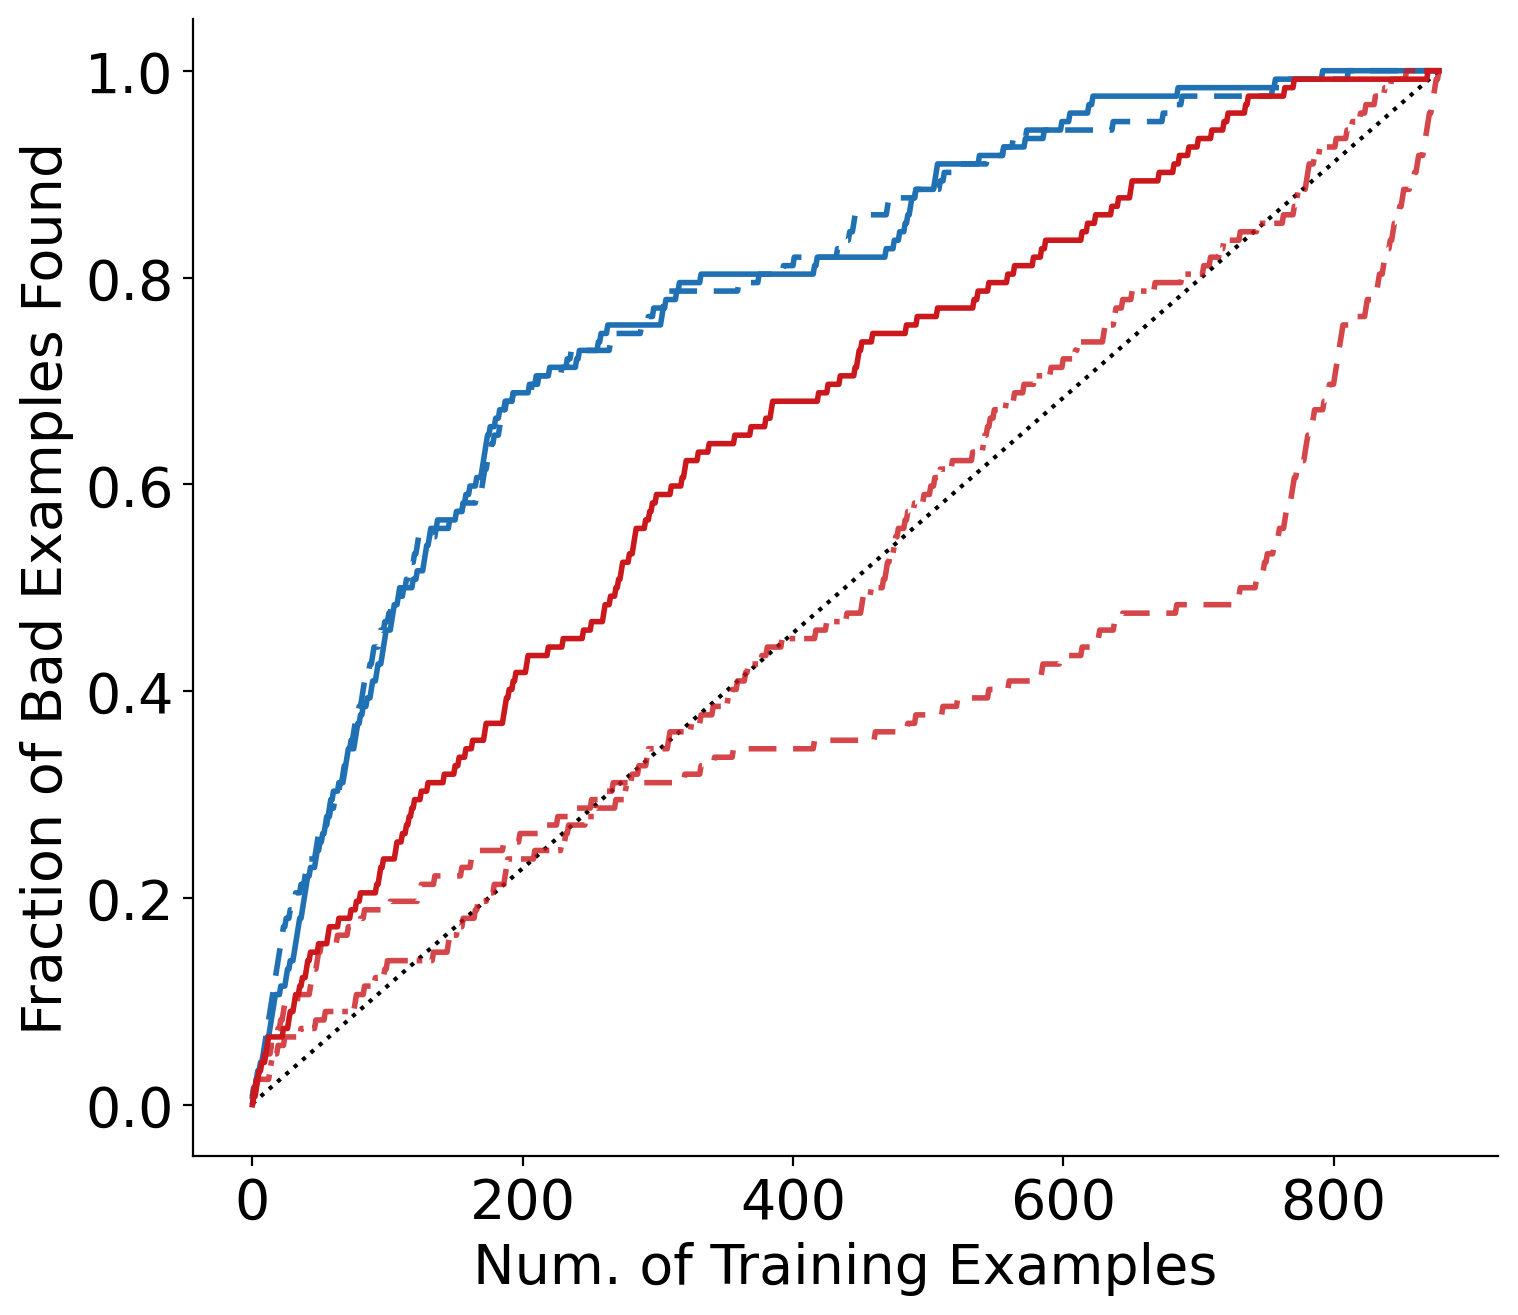

In [20]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
order = lambda scores: [scores[x.id] for x in data["original_train_docs"]]

base_cmap = plt.cm.get_cmap(plt.get_cmap("Blues"))(np.linspace(0.5, 1, 3))
inf_cmap = plt.cm.get_cmap(plt.get_cmap("Reds"))(np.linspace(0.5, 1, 3))

fig = plt.figure(figsize=(8, 7))
ax = plt.subplot(111)
changes = np.array(changes)
N = sum(changes) #/ 100
ax.plot(np.cumsum(sum(changes) / len(changes) * np.ones_like(changes)) / N, label="Random", linestyle=":", c="black")
ax.plot(np.cumsum(changes[np.argsort(-np.array(order(instance_losses)))]) / N, label="Instance Loss", c=base_cmap[1], linewidth=2, linestyle=(0, (5, 3)))
ax.plot(np.cumsum(changes[np.argsort(-np.array(order(token_marginal_mean_loss)))]) / N, label="Token Marginal Mean Loss", c=base_cmap[1], linewidth=2, linestyle="solid")

ax.plot(np.cumsum(changes[np.argsort(-np.array(instance_influence_scores))]) / N, label="Instance Influence", c=inf_cmap[1], linewidth=2, linestyle=(0, (5, 3)), alpha=0.8) # Check
ax.plot(np.cumsum(changes[np.argsort(-np.array(entity_influence_max))]) / N, label="Max Segment Influence", c=inf_cmap[1], linewidth=2, linestyle="solid")
ax.plot(np.cumsum(changes[np.argsort(-np.array(entity_sim_max))]) / N, label="Max Segment NN", c=inf_cmap[1], linewidth=2, linestyle="-.", alpha=0.8)

ax.set_xlabel("Num. of Training Examples")
ax.set_ylabel("Fraction of Bad Examples Found")

label_params = ax.get_legend_handles_labels() 
plt.tight_layout()
plt.savefig(f"CoNLL_errors.pdf", bbox_inches='tight')

/tmp/ipykernel_98445/3233076738.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  figl.tight_layout()


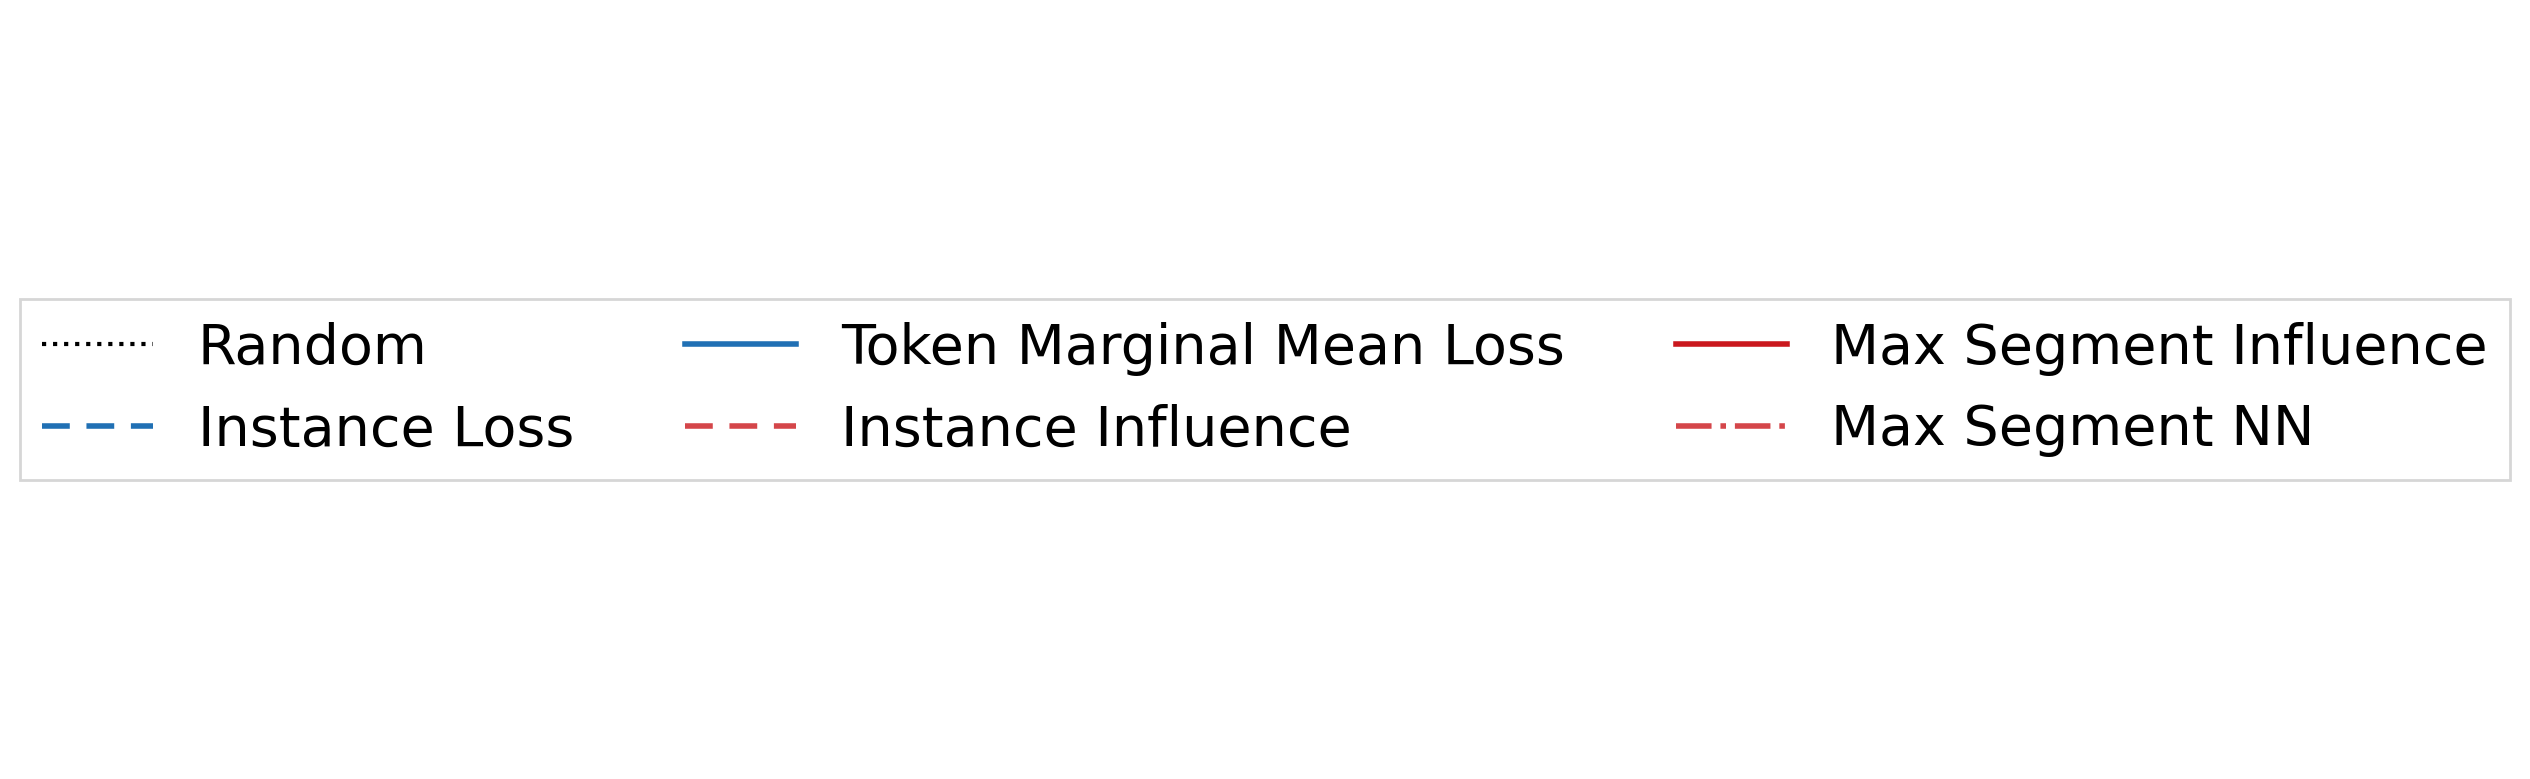

In [18]:
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, ncol=3, shadow=False, fancybox=False, loc="center", bbox_to_anchor=(0.5, 0.5))
figl.tight_layout()
figl.savefig(f"CoNLL_errors_legend.pdf", bbox_inches='tight')

In [ ]:
base_methods = {
    "Instance Loss": instance_losses,
    "Instance Gradient": instance_gradient,
    "Token Max Loss": token_marginal_max_loss,
    "Token Mean Loss": token_marginal_mean_loss,
    "Token Max Entropy": token_marginal_max_ent,
    "Token Mean Entropy": token_marginal_mean_ent,
    "Token Max Gradient": token_marginal_max_grad,
    "Token Mean Gradient": token_marginal_mean_grad,
}

inf_methods = {
    "Instance Influence": instance_influence_scores,
    "Segment Influence (Max)": entity_influence_max,
    "Segment Influence (Mean)": entity_influence_mean,
    "Segment NN (Max)": entity_sim_max,
    "Segment NN (Mean)": entity_sim_mean,
}

In [ ]:
from itertools import cycle, product
order = lambda scores: [scores[x.id] for x in data["original_train_docs"]]

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams.update({"font.size": 20})
import numpy as np

base_color_cycle = list(plt.cm.get_cmap(plt.get_cmap("Blues"))(np.linspace(0.5, 1, 3)))[::-1]
base_linestyle_cycle = ["solid", "dashed", "dashdot", "dotted"]
base_cycle = cycle(list(product(base_color_cycle, base_linestyle_cycle)))

inf_color_cycle = list(plt.cm.get_cmap(plt.get_cmap("Reds"))(np.linspace(0.5, 1, 3)))[::-1]
inf_linestyle_cycle = ["solid", "dashed", "dashdot", "dotted"]
inf_cycle = cycle(list(product(inf_color_cycle, inf_linestyle_cycle)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
N = sum(changes)


changes = np.array(changes)
ax.plot(
    np.cumsum(sum(changes) / len(changes) * np.ones_like(changes)) / N,
    label="Random",
    linestyle=":",
    c="black",
)


for method, scores in base_methods.items():
    c, linestyle = next(base_cycle)
    ax.plot(
        np.cumsum(changes[np.argsort(-np.array(order(scores)))]) / N,
        label=method,
        linestyle=linestyle,
        c=c,
    )

for method, scores in inf_methods.items():
    c, linestyle = next(inf_cycle)
    ax.plot(
        np.cumsum(changes[np.argsort(-np.array(scores))]) / N,
        label=method,
        linestyle=linestyle,
        c=c,
    )

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=2, frameon=False)
label_params = ax.get_legend_handles_labels() 
ax.set_xlabel("Num. of Training Examples")
ax.set_ylabel("Fraction of Bad Examples Found")
fig.tight_layout()
plt.savefig(f"CoNLL_errors_full.pdf", bbox_inches='tight')

In [ ]:
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, ncol=2, shadow=False, fancybox=False, loc="center", bbox_to_anchor=(0.5, 0.5))
figl.tight_layout()
figl.savefig(f"CoNLL_errors_full_legend.pdf", bbox_inches='tight')